# Tech Intro

## Main tables

In [312]:
# Real Estate's objects
real_estate_list: list = [
    'ag_object',
    'ag_parse_ad',
    'ag_lead_object',
    'ag_presentation_object',
    'ag_object_platform',
    'ag_posting_ad_realty',
    'native_realty_filial',
    'foreign_realty_filial',
    'spr_metro',
    'spr_metro_connection',
    'ag_object_parking']
# Lead's objects
lead_list: list = [
    'leads',
    'lead_utm',
    'client_wishes',
    'leads_email_order',
    'request_from_site',
    'lead_finance',
    'leads_source_spr',
    'leads_calls_connection',
    'leads_pipeline',
    'leads_not_implemented_reason',
    'leads_status',
    'ag_pipeline',
    'ag_pipeline_status',
    'leads_meta',
    'leads_meta_fields',
    'leads_meta_group',
    'leads_contacts_connect',
    'leads_contact',
    'leads_contact_meta',
    'leads_contact_meta_fields']
# Deal's objects
deal_list: list = [
    # Deal
    'a_deal',
    'a_deal_meta',
    'deal_passport',
    'a_deal_finance',
    'a_deal_check',
    'a_deal_test',
    # Contractor
    'a_contractor',
    'a_contractor_meta',
    'a_deal_contractor',
    'a_deal_contractor_meta',
    # Object
    'a_object',
    'a_object_meta',
    'a_deal_object']

## Main Variables

In [313]:
# Address and name of your notebook
venv_path = "/home/bigdata/a.umarov/jupyter_P24"
# Exploratory Data Analysis(EDA) table of leads (leads)
leads = lead_list[12] # You can generate full-EDA cycle if you want through the all of tables
                                # Just iterate it !
# Exploratory Data Analysis(EDA) obj as PySpark DataFrame (see above)
leads_df = None
# Set the date of checking
sample_data_date = '20221101'

## Useful command and modules (can be transform into the 'importlib'- smart import logic)

In [314]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

#Not necessary
%matplotlib inline
# To data analyze need the module
import pyspark.pandas as ps
os.environ["PYSPARK_PYTHON"] = f"{venv_path}/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = f"{venv_path}/bin/python3"

import findspark
findspark.init("/opt/dev/spark/spark")
 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext, DataFrameNaFunctions, \
                        Window, DataFrame, DataFrameStatFunctions, \
                        Column, Row, GroupedData, functions, types
from pyspark.sql.functions import isnan, when, count, col, to_date, from_unixtime

# spark.conf.set("spark.sql.session.timeZone", "America/Los_Angeles")
conf = SparkConf().setAppName("get_info_from_" + leads + "_table")
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

## Read the spec-file from Hadoop and show some data sample

In [315]:
leads_df = spark.read.parquet("/prod/source/p24/" + leads + "/datekey=" + sample_data_date)
leads_df.show(10, False)

+----+-----------------------+-------+----+--------------+-----------+----------+----------+----------+----------+-------+---+----------+----------+
|id  |name                   |color  |sort|ag_pipeline_id|is_editable|created_at|created_by|updated_at|updated_by|deleted|ad |visible_bc|visible_pc|
+----+-----------------------+-------+----+--------------+-----------+----------+----------+----------+----------+-------+---+----------+----------+
|1   |В работе               |#f26065|0   |1             |0          |1583920342|1         |1638788833|11864     |0      |0  |1         |0         |
|10  |Аванс / Задаток / Бронь|#32b76c|2   |2             |0          |1583920342|1         |1617270090|3360143   |0      |1  |0         |1         |
|100 |Реклама                |#fde3c3|3   |17            |0          |1594024918|11864     |1657284593|3799485   |0      |1  |0         |1         |
|1000|Переговоры             |#f47769|0   |167           |0          |1603349200|3790764   |1603349200|379

## Show columns' properties

In [316]:
print('Data overview')
leads_df.printSchema()

Data overview
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- color: string (nullable = true)
 |-- sort: string (nullable = true)
 |-- ag_pipeline_id: string (nullable = true)
 |-- is_editable: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- created_by: string (nullable = true)
 |-- updated_at: string (nullable = true)
 |-- updated_by: string (nullable = true)
 |-- deleted: string (nullable = true)
 |-- ad: string (nullable = true)
 |-- visible_bc: string (nullable = true)
 |-- visible_pc: string (nullable = true)



## Total rows (count)

In [317]:
leads_df.count()

6052

## Simple func to execute and show the result of the SQL-instruction

In [318]:
def execute(select_instruction: str = "select count(*) from leads_sql") -> object:
    """
    Method to execute and show the result of your SQL-instruction
    :default -> "select count(*) from leads_sql"
    :param :string select_instruction: SQL statement
    :return: result of the SQL-operation as a table
    """
    return spark.sql(select_instruction).show(truncate = False)

## Create the Leads'  temp-table-view from the DF (called as "leads_sql")

In [319]:
leads_df.createOrReplaceTempView("leads_sql")

### SQL-instructions

#### Create Engaging Visuals to Highlight Important Sales Metrics 

#### Each type of Customer's Communication Channels (count)

In [320]:
# Creating pandas DF
lead_per_type = spark.sql(
     """SELECT create_type AS `Канал создания`\
        , from_unixtime(date_create, 'yyyy / MM') AS `Год / месяц`\
        , count(from_unixtime(date_create, 'yyyy / MM')) AS Count\
        FROM leads_sql\
        WHERE date_create IS NOT null\
              AND\
              from_unixtime(date_create, 'yyyyMM') >= 202201\
              AND\
              deleted = 0
        GROUP BY create_type\
            ,from_unixtime(date_create, 'yyyy / MM') \
        ORDER BY from_unixtime(date_create, 'yyyy / MM')""").toPandas()

AnalysisException: cannot resolve 'date_create' given input columns: [leads_sql.ad, leads_sql.ag_pipeline_id, leads_sql.color, leads_sql.created_at, leads_sql.created_by, leads_sql.deleted, leads_sql.id, leads_sql.is_editable, leads_sql.name, leads_sql.sort, leads_sql.updated_at, leads_sql.updated_by, leads_sql.visible_bc, leads_sql.visible_pc]; line 1 pos 205;
'Sort ['from_unixtime('date_create, yyyy / MM) ASC NULLS FIRST], true
+- 'Aggregate ['create_type, 'from_unixtime('date_create, yyyy / MM)], ['create_type AS Канал создания#4418, 'from_unixtime('date_create, yyyy / MM) AS Год / месяц#4419, 'count('from_unixtime('date_create, yyyy / MM)) AS Count#4420]
   +- 'Filter ((isnotnull('date_create) AND ('from_unixtime('date_create, yyyyMM) >= 202201)) AND (cast(deleted#4324 as int) = 0))
      +- SubqueryAlias leads_sql
         +- View (`leads_sql`, [id#4314,name#4315,color#4316,sort#4317,ag_pipeline_id#4318,is_editable#4319,created_at#4320,created_by#4321,updated_at#4322,updated_by#4323,deleted#4324,ad#4325,visible_bc#4326,visible_pc#4327])
            +- Relation [id#4314,name#4315,color#4316,sort#4317,ag_pipeline_id#4318,is_editable#4319,created_at#4320,created_by#4321,updated_at#4322,updated_by#4323,deleted#4324,ad#4325,visible_bc#4326,visible_pc#4327] parquet


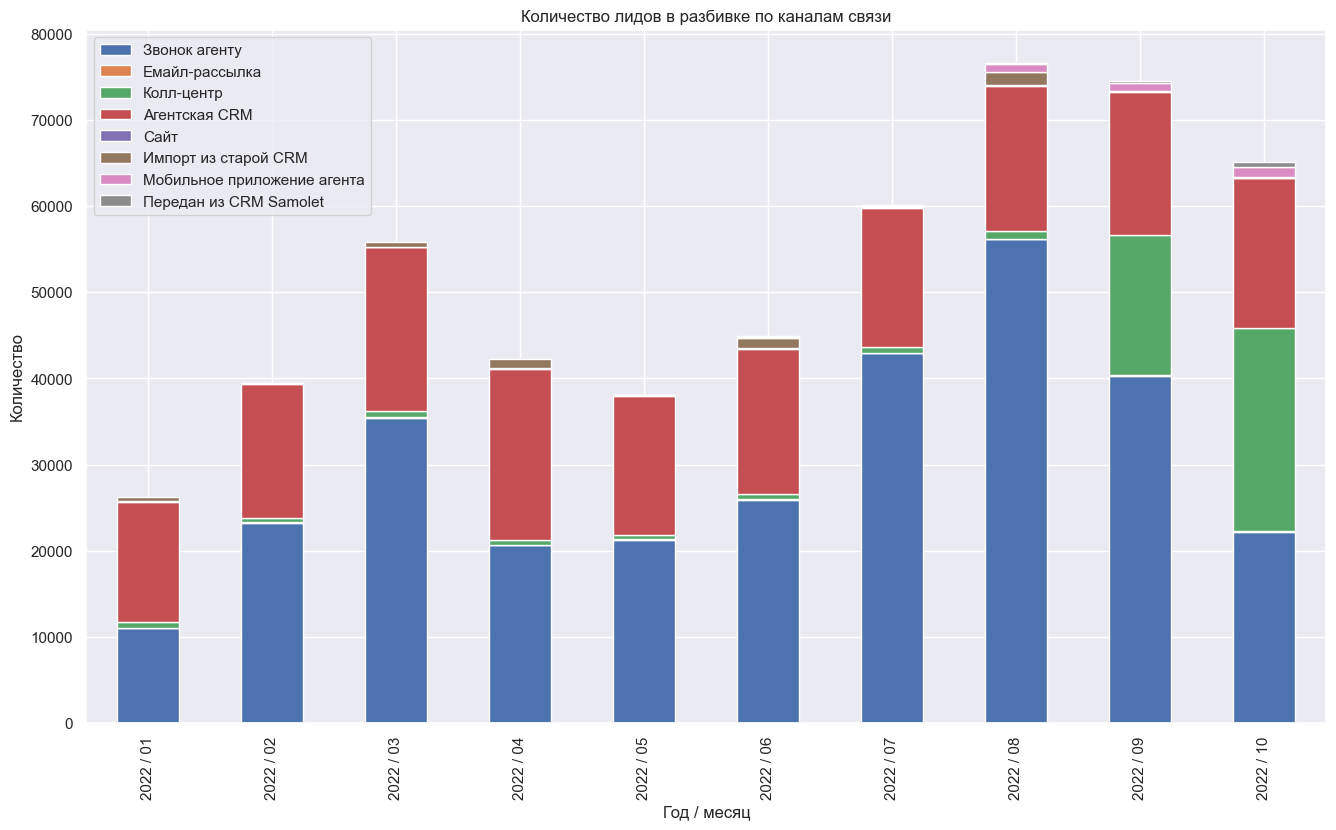

In [321]:
# Set the size
plt.rcParams["figure.figsize"] = [16,9]

lead_per_type.pivot_table(index = 'Год / месяц',
                          columns = 'Канал создания' ,
                          values = 'Count').plot(kind = 'bar', stacked = True)

# Custom legend
plt.legend(['Звонок агенту',
            'Емайл-рассылка',
            'Колл-центр',
            'Агентская CRM',
            'Сайт',
            'Импорт из старой CRM',
            'Мобильное приложение агента',
            'Передан из CRM Samolet'])

# labels for x & y axis
plt.xlabel('Год / месяц')
plt.ylabel('Количество')

# Title of plot
plt.title('Количество лидов в разбивке по каналам связи');

In [322]:
spark.stop()